<a href="https://colab.research.google.com/github/CodingWithMK/MoveToNight_Movie-Recommendation-System/blob/main/MoveToNight_Content_Based_Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import numpy as np
import pandas as pd
import os
import json
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tmdb/tmdb-movie-metadata")

print("Path to dataset files:", path)

100%|██████████| 8.89M/8.89M [00:00<00:00, 59.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tmdb/tmdb-movie-metadata/versions/2


In [3]:
# Dosya yollarınızı belirtin:
movies_path = "/root/.cache/kagglehub/datasets/tmdb/tmdb-movie-metadata/versions/2/tmdb_5000_movies.csv"
credits_path = "/root/.cache/kagglehub/datasets/tmdb/tmdb-movie-metadata/versions/2/tmdb_5000_credits.csv"

# CSV dosyalarını pandas ile okuyalım:
movies = pd.read_csv(movies_path)
credits = pd.read_csv(credits_path)

In [4]:
# Veri setlerinin ilk birkaç satırına göz atalım:
print("Movies dataset (First 5 Columns):")
movies.head()

Movies dataset (First 5 Columns):


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
print("\nCredits dataset (First 5 Columns):")
credits.head()


Credits dataset (First 5 Columns):


,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [6]:
movies = movies.dropna()
credits = credits.dropna()

In [7]:
# "id" sütunu üzerinden veri setlerini birleştirelim:
tmdb_df = movies.merge(credits, on="title")

# Birleştirilmiş veri setinin boyutuna ve ilk satırlarına bakalım:
print("Birleştirilmiş veri seti boyutu:", tmdb_df.shape)
tmdb_df.head()

Birleştirilmiş veri seti boyutu: (1494, 23)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [8]:
# Eksik değerlerin kontrolü:
print("Null Values:")
print(tmdb_df.isnull().sum())

# Temel istatistiksel özet:
print("\nDescriptive Statistics:")
tmdb_df.describe()

Null Values:
budget                  0
genres                  0
homepage                0
id                      0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
movie_id                0
cast                    0
crew                    0
dtype: int64

Descriptive Statistics:


,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id
count,1.494000e+03,1494.000000,1494.000000,1.494000e+03,1494.000000,1494.000000,1494.00000,1494.000000
mean,4.587198e+07,65455.551539,35.743863,1.549638e+08,108.664659,6.273159,1323.03079,65503.379518
std,5.368180e+07,89827.109601,48.191833,2.407967e+08,19.374115,0.970217,1791.97417,89811.925093
min,0.000000e+00,11.000000,0.023681,0.000000e+00,0.000000,0.000000,0.00000,11.000000
25%,7.500000e+06,8071.250000,11.627393,9.461354e+06,95.000000,5.800000,207.25000,8102.750000
50%,2.700000e+07,26245.500000,25.281258,6.258280e+07,106.000000,6.300000,614.50000,26354.000000
75%,6.300000e+07,76340.250000,45.133338,1.859828e+08,120.000000,6.900000,1652.00000,76340.250000
max,3.800000e+08,426469.000000,875.581305,2.787965e+09,201.000000,8.400000,13752.00000,426469.000000


In [9]:
import ast

# 'genres' sütunundaki string ifadeleri sözlük/list tipine çevirme fonksiyonu:
def parse_genres(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        return [genre['name'] for genre in genres_list]
    except:
        return []

# Yeni bir sütun oluşturarak, her filmin genre bilgilerini liste halinde saklayalım:
tmdb_df['genres_parsed'] = tmdb_df['genres'].apply(parse_genres)

# Örnek sonuç:
print(tmdb_df[['title', 'genres_parsed']].head())

                                      title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                   genres_parsed  
0  [Action, Adventure, Fantasy, Science Fiction]  
1                   [Adventure, Fantasy, Action]  
2                     [Action, Adventure, Crime]  
3               [Action, Crime, Drama, Thriller]  
4           [Action, Adventure, Science Fiction]  


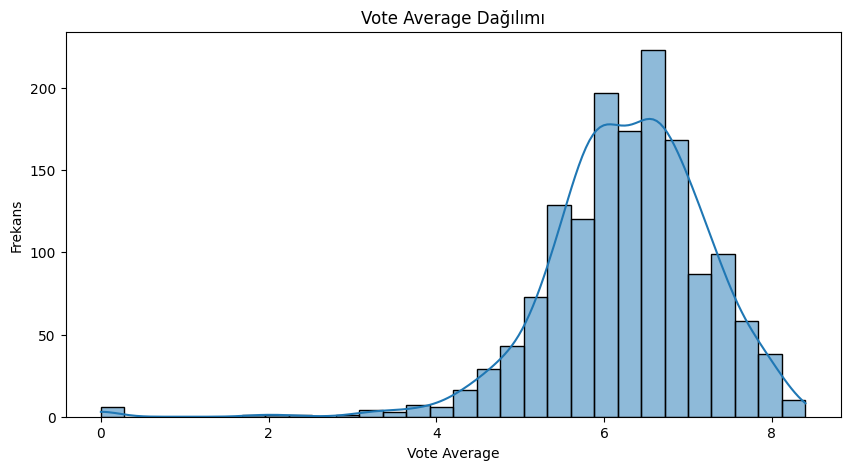

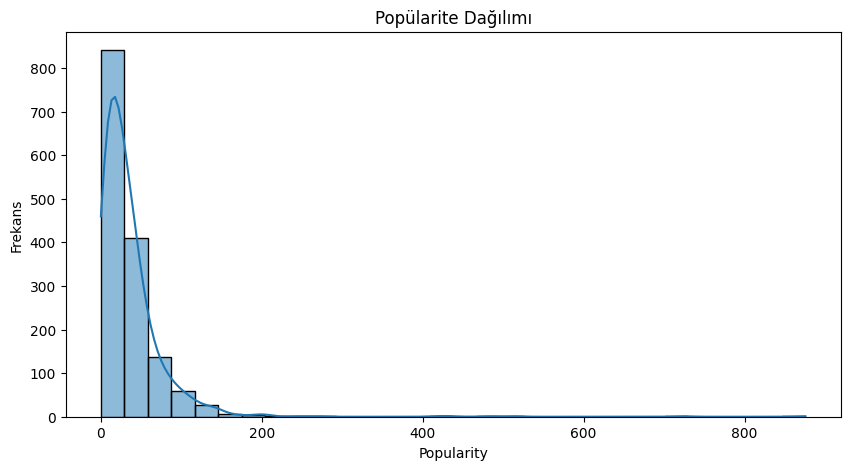

In [10]:
# Oy ortalaması dağılımı:
plt.figure(figsize=(10,5))
sns.histplot(tmdb_df['vote_average'], bins=30, kde=True)
plt.title("Vote Average Dağılımı")
plt.xlabel("Vote Average")
plt.ylabel("Frekans")
plt.show()

# Popülarite dağılımı:
plt.figure(figsize=(10,5))
sns.histplot(tmdb_df['popularity'], bins=30, kde=True)
plt.title("Popülarite Dağılımı")
plt.xlabel("Popularity")
plt.ylabel("Frekans")
plt.show()

In [11]:
# 'release_date' sütununu datetime tipine çevirelim:
tmdb_df['release_date'] = pd.to_datetime(tmdb_df['release_date'], errors='coerce')

# Yıl bilgisini yeni bir sütun olarak ekleyelim:
tmdb_df['release_year'] = tmdb_df['release_date'].dt.year

# İlk örnek:
print(tmdb_df[['title', 'release_date', 'release_year']].head())

                                      title release_date  release_year
0                                    Avatar   2009-12-10          2009
1  Pirates of the Caribbean: At World's End   2007-05-19          2007
2                                   Spectre   2015-10-26          2015
3                     The Dark Knight Rises   2012-07-16          2012
4                               John Carter   2012-03-07          2012


# Preprocessing the TMDB Dataset

In this section, we perform data preprocessing to remove unnecessary columns and prepare our data for further analysis. We remove columns that are not directly useful for building a recommendation model. For example, columns like `budget`, `homepage`, and `tagline` typically do not contribute to the recommendation logic and can be removed.

Additionally, you may choose to drop other columns that provide highly specific information (e.g. `production_companies`, `production_countries`, and `spoken_languages`) to simplify the dataset. However, if you plan to use them in future feature engineering or content-based filtering, you might want to keep a copy for further analysis.

In [12]:
columns_to_drop = [
    'budget',                # Financial info that is less relevant for recommendation.
    'homepage',              # Not required for modeling.
    'production_companies',  # Detailed production info, can be dropped or processed separately.
    'production_countries',  # Similar reasoning as above.
    'spoken_languages',      # Language details, can be removed to simplify the dataset.
    'movie_id',
    'popularity',
    'revenue',
    'status',
    'cast',
    'crew'
]

In [13]:
# Drop the columns from the merged dataframe (tmdb_df)
tmdb_df_cleaned = tmdb_df.drop(columns=columns_to_drop)

In [14]:
# Display the columns of the preprocessed dataframe to confirm the unnecessary columns have been removed.
print("Columns in the preprocessed dataset:")
print(tmdb_df_cleaned.columns.tolist())

Columns in the preprocessed dataset:
['genres', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'release_date', 'runtime', 'tagline', 'title', 'vote_average', 'vote_count', 'genres_parsed', 'release_year']


In [16]:
tmdb_df_cleaned.head()

,genres,id,keywords,original_language,original_title,overview,release_date,runtime,tagline,title,vote_average,vote_count,genres_parsed,release_year
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",2009-12-10,162.0,Enter the World of Pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]",2009
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",2007-05-19,169.0,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[Adventure, Fantasy, Action]",2007
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,2015-10-26,148.0,A Plan No One Escapes,Spectre,6.3,4466,"[Action, Adventure, Crime]",2015
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,2012-07-16,165.0,The Legend Ends,The Dark Knight Rises,7.6,9106,"[Action, Crime, Drama, Thriller]",2012
4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",2012-03-07,132.0,"Lost in our world, found in another.",John Carter,6.1,2124,"[Action, Adventure, Science Fiction]",2012


In [17]:
print("Cleaned dataset shape:", tmdb_df_cleaned.shape)

Cleaned dataset shape: (1494, 14)


In [18]:
tmdb_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genres             1494 non-null   object        
 1   id                 1494 non-null   int64         
 2   keywords           1494 non-null   object        
 3   original_language  1494 non-null   object        
 4   original_title     1494 non-null   object        
 5   overview           1494 non-null   object        
 6   release_date       1494 non-null   datetime64[ns]
 7   runtime            1494 non-null   float64       
 8   tagline            1494 non-null   object        
 9   title              1494 non-null   object        
 10  vote_average       1494 non-null   float64       
 11  vote_count         1494 non-null   int64         
 12  genres_parsed      1494 non-null   object        
 13  release_year       1494 non-null   int32         
dtypes: datet

In [19]:
print(tmdb_df_cleaned.isnull().sum())

genres               0
id                   0
keywords             0
original_language    0
original_title       0
overview             0
release_date         0
runtime              0
tagline              0
title                0
vote_average         0
vote_count           0
genres_parsed        0
release_year         0
dtype: int64


## 1. Filtering Top 100 Similar Movies by "keywords", "tagline", "genres"

In [20]:
tmdb_df_cleaned.genres[0]

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [21]:
tmdb_df_cleaned.keywords[0]

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [22]:
tmdb_df_cleaned.tagline[0]

'Enter the World of Pandora.'

In [23]:
tmdb_keywords_tagline_genres = tmdb_df_cleaned[['id', 'original_title']]

In [24]:
tmdb_keywords_tagline_genres.head()

,id,original_title
0,19995,Avatar
1,285,Pirates of the Caribbean: At World's End
2,206647,Spectre
3,49026,The Dark Knight Rises
4,49529,John Carter


In [25]:
tmdb_keywords_tagline_genres["genres_combined"] = tmdb_df_cleaned.genres.apply(lambda row: ' ' . join([x['name'].lower() for x in json.loads(row)]))
tmdb_keywords_tagline_genres["keywords_combined"] = tmdb_df_cleaned.keywords.apply(lambda row: ' ' . join([x['name'].lower() for x in json.loads(row)]))
tmdb_keywords_tagline_genres["tagline_processed"] = tmdb_df_cleaned.tagline.apply(lambda row: row.lower())

In [26]:
tmdb_keywords_tagline_genres["keywords_taglines_genres"] = tmdb_keywords_tagline_genres.apply((lambda row: ' ' . join([row.genres_combined, row.keywords_combined, row.tagline_processed])), axis=1)

In [27]:
tmdb_keywords_tagline_genres.head()

,id,original_title,genres_combined,keywords_combined,tagline_processed,keywords_taglines_genres
0,19995,Avatar,action adventure fantasy science fiction,culture clash future space war space colony so...,enter the world of pandora.,action adventure fantasy science fiction cultu...
1,285,Pirates of the Caribbean: At World's End,adventure fantasy action,ocean drug abuse exotic island east india trad...,"at the end of the world, the adventure begins.",adventure fantasy action ocean drug abuse exot...
2,206647,Spectre,action adventure crime,spy based on novel secret agent sequel mi6 bri...,a plan no one escapes,action adventure crime spy based on novel secr...
3,49026,The Dark Knight Rises,action crime drama thriller,dc comics crime fighter terrorist secret ident...,the legend ends,action crime drama thriller dc comics crime fi...
4,49529,John Carter,action adventure science fiction,based on novel mars medallion space travel pri...,"lost in our world, found in another.",action adventure science fiction based on nove...


In [29]:
tmdb_keywords_tagline_genres = tmdb_keywords_tagline_genres.sort_values("id")
tmdb_keywords_tagline_genres = tmdb_keywords_tagline_genres.reset_index(drop=True)

In [30]:
tmdb_keywords_tagline_genres.head()

,id,original_title,genres_combined,keywords_combined,tagline_processed,keywords_taglines_genres
0,11,Star Wars,adventure action science fiction,android galaxy hermit death star lightsaber je...,"a long time ago in a galaxy far, far away...",adventure action science fiction android galax...
1,12,Finding Nemo,animation family,father son relationship harbor underwater fish...,"there are 3.7 trillion fish in the ocean, they...",animation family father son relationship harbo...
2,14,American Beauty,drama,male nudity female nudity adultery midlife cri...,look closer.,drama male nudity female nudity adultery midli...
3,22,Pirates of the Caribbean: The Curse of the Bla...,adventure fantasy action,exotic island blacksmith east india trading co...,prepare to be blown out of the water.,adventure fantasy action exotic island blacksm...
4,24,Kill Bill: Vol. 1,action crime,japan coma martial arts kung fu underworld yak...,go for the kill.,action crime japan coma martial arts kung fu u...


In [33]:
tmdb_keywords_tagline_genres.keywords_taglines_genres

,keywords_taglines_genres
0,adventure action science fiction android galax...
1,animation family father son relationship harbo...
2,drama male nudity female nudity adultery midli...
3,adventure fantasy action exotic island blacksm...
4,action crime japan coma martial arts kung fu u...
...,...
1489,comedy alcohol bar party divorce family hit an...
1490,action drama new jersey martial arts sister sp...
1491,adventure blow job cigarette smoking illegal d...
1492,drama undercover dog animal welfare animal rig...


In [35]:
vectorizer = CountVectorizer(stop_words='english')
vectorized = vectorizer.fit_transform(tmdb_keywords_tagline_genres.keywords_taglines_genres)

In [36]:
vectorized.toarray().shape

(1494, 5591)

In [37]:
vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
top10words = vectorizer.get_feature_names_out()
top10words

array(['000', '007', '05', ..., 'zwei', 'γη', '最后的舞者'], dtype=object)

In [39]:
top_freqs = vectorized.sum(axis=0).A1 # sum matrix into a 1D NumPy array
top_freqs

array([10,  6,  2, ...,  1,  1,  1])

In [44]:
sorted_indices = top_freqs.argsort()[::-1] # Sort the words by frequency in descending order
top10words = [top10words[idx] for idx in sorted_indices]
top_freqs = top_freqs[sorted_indices]

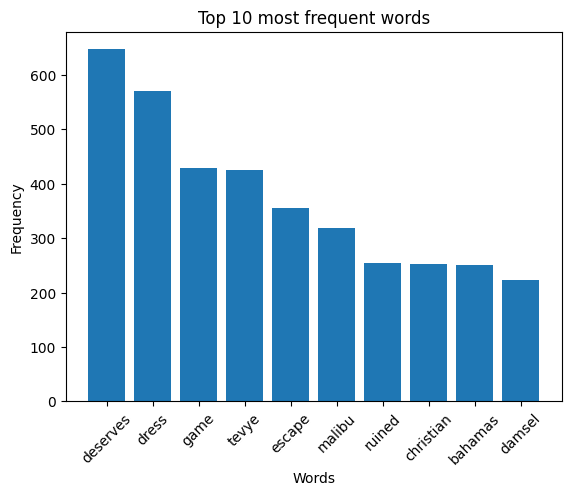

In [46]:
plt.bar(top10words[:10], top_freqs[:10])
plt.xlabel('Words')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 most frequent words')
plt.show()

In [49]:
word_freqs = {}
for x in list(pd.DataFrame([top10words, top_freqs]).transpose().apply(lambda row: {row[0]: row[1]}, axis=1)):
    for key, val in x.items():
        word_freqs[key] = val

(np.float64(-0.5), np.float64(999.5), np.float64(399.5), np.float64(-0.5))

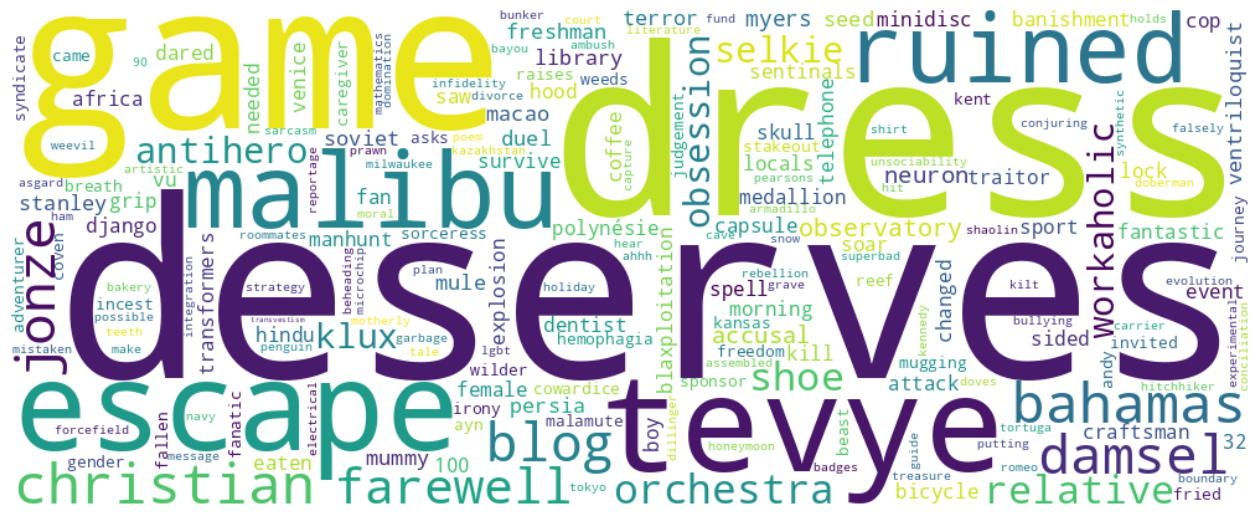

In [54]:
word_cloud = wordcloud.WordCloud(width=1000, height=400, background_color='white')
word_cloud.generate_from_frequencies(word_freqs)
plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')

Now we use consine similarity to find the similarity. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. It is often used in natural language processing and information retrieval to measure how similar two documents are based on their content. The value of cosine similarity ranges from -1 to 1, with 1 indicating that the two vectors are identical and 0 indicating that they are completely dissimilar. Higher values of cosine similarity indicate greater similarity between the vectors.


The formula for cosine similarity between two vectors A and B can be expressed as:

cosine_similarity = (A . B) / (||A|| ||B||)

where A . B represents the dot product of A and B, and ||A|| and ||B|| represent the magnitudes of A and B, respectively.

In [57]:
cosine_results = cosine_similarity(vectorized.toarray())
pd.DataFrame(cosine_results)

,0,1,2,3,4,5,6,7,8,9,...,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493
0,1.000000,0.000000,0.026398,0.054133,0.033150,0.081992,0.000000,0.057977,0.069007,0.000000,...,0.000000,0.000000,0.207020,0.050965,0.0,0.000000,0.031388,0.040996,0.000000,0.000000
1,0.000000,1.000000,0.049386,0.025318,0.031009,0.000000,0.262202,0.081349,0.032275,0.000000,...,0.000000,0.000000,0.000000,0.047673,0.0,0.040825,0.000000,0.000000,0.000000,0.064550
2,0.026398,0.049386,1.000000,0.000000,0.030628,0.037878,0.047088,0.107134,0.000000,0.034922,...,0.045083,0.069843,0.063758,0.000000,0.0,0.040324,0.029001,0.000000,0.033296,0.127515
3,0.054133,0.025318,0.000000,1.000000,0.031404,0.000000,0.024140,0.000000,0.490290,0.000000,...,0.000000,0.000000,0.065372,0.144841,0.0,0.000000,0.029735,0.038837,0.000000,0.000000
4,0.033150,0.031009,0.030628,0.031404,1.000000,0.000000,0.029566,0.000000,0.040032,0.000000,...,0.000000,0.000000,0.080064,0.059131,0.0,0.000000,0.182089,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,0.000000,0.040825,0.040324,0.000000,0.000000,0.000000,0.155700,0.000000,0.000000,0.000000,...,0.074536,0.115470,0.105409,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.210819
1490,0.031388,0.000000,0.029001,0.029735,0.182089,0.045038,0.000000,0.031846,0.037905,0.041523,...,0.053606,0.000000,0.075810,0.000000,0.0,0.000000,1.000000,0.000000,0.039590,0.075810
1491,0.040996,0.000000,0.000000,0.038837,0.000000,0.000000,0.000000,0.000000,0.049507,0.000000,...,0.000000,0.000000,0.000000,0.073127,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
1492,0.000000,0.000000,0.033296,0.000000,0.000000,0.051709,0.000000,0.036564,0.000000,0.047673,...,0.061546,0.000000,0.000000,0.000000,0.0,0.000000,0.039590,0.000000,1.000000,0.087039


Now that we have the cosine similarity table for each movie, we can retrieve the movie ID that the user just watched and find its similarity with other movies.

In [60]:
[result for result in tmdb_keywords_tagline_genres["original_title"] if 'iron' in result.lower()]

['Iron Man', 'Iron Man 2', 'The Iron Giant', 'Iron Man 3', 'The Iron Lady']

In [61]:
movie_title = "Iron Man"
movie_index = [index for index, x in enumerate(tmdb_keywords_tagline_genres["original_title"] == movie_title) if x == True][0]

In [62]:
movie_index

219

Once we obtain the movie index, we can utilize the cosine_similarity matrix to determine the 100 most similar movies to the movie ID that the user watched.

In [63]:
top_100_movies = sorted(list(enumerate(cosine_results[movie_index])), key=lambda x: x[1], reverse=True)[:100]

In [64]:
top_100_movies[:10]

[(219, np.float64(1.0)),
 (466, np.float64(0.6761234037828133)),
 (1208, np.float64(0.6696620080077292)),
 (1075, np.float64(0.6335564128181456)),
 (1202, np.float64(0.5963765795456271)),
 (733, np.float64(0.5863527298559492)),
 (1200, np.float64(0.5749889084999458)),
 (1395, np.float64(0.5649883385169099)),
 (1119, np.float64(0.5303948353054367)),
 (222, np.float64(0.4955585044094361))]

In [65]:
top_movies = pd.DataFrame(np.squeeze(tmdb_keywords_tagline_genres.values[[np.array(top_100_movies)[:, 0].astype(int)]]), columns=tmdb_keywords_tagline_genres.columns)
top_movies.head(101)

,id,original_title,genres_combined,keywords_combined,tagline_processed,keywords_taglines_genres
0,1726,Iron Man,action science fiction adventure,middle east arms dealer malibu marvel comic su...,heroes aren't born. they're built.,action science fiction adventure middle east a...
1,10138,Iron Man 2,adventure action science fiction,malibu marvel comic superhero based on comic b...,"it's not the armor that makes the hero, but th...",adventure action science fiction malibu marvel...
2,102899,Ant-Man,science fiction action adventure,marvel comic superhero based on comic book aft...,heroes don't get any bigger.,science fiction action adventure marvel comic ...
3,68721,Iron Man 3,action adventure science fiction,terrorist war on terror tennessee malibu marve...,unleash the power behind the armor.,action adventure science fiction terrorist war...
4,100402,Captain America: The Winter Soldier,action adventure science fiction,washington d.c. future shield marvel comic sup...,in heroes we trust.,action adventure science fiction washington d....
...,...,...,...,...,...,...
95,285,Pirates of the Caribbean: At World's End,adventure fantasy action,ocean drug abuse exotic island east india trad...,"at the end of the world, the adventure begins.",adventure fantasy action ocean drug abuse exot...
96,1487,Hellboy,fantasy action science fiction,black magic fistfight cover-up superhero paran...,from the dark side to our side.,fantasy action science fiction black magic fis...
97,6479,I Am Legend,drama horror action thriller science fiction,saving the world lost civilisation post-apocal...,the last man on earth is not alone,drama horror action thriller science fiction s...
98,68726,Pacific Rim,action science fiction adventure,dystopia giant robot giant monster apocalypse ...,"to fight monsters, we created monsters",action science fiction adventure dystopia gian...


So we now have the top 100 recommended movie that similar to the one that watched by the user. We can ignore the first actually, because it's the movie that the user wathced itself.

In [24]:
import json

# Process genres: parse the JSON string, extract the genre names, convert them to lowercase, and join with space.
def process_genres(genres_str):
    try:
        genres_list = json.loads(genres_str)
        return " ".join([genre["name"].lower() for genre in genres_list])
    except Exception as e:
        return ""

tmdb_df_cleaned["genres_processed"] = tmdb_df_cleaned["genres"].apply(process_genres)

# Process tagline: fill missing values with empty string and convert to lowercase.
tmdb_df_cleaned["tagline_processed"] = tmdb_df_cleaned["tagline"].fillna("").str.lower()

# Preview the processed columns for a few rows.
print(tmdb_df_cleaned[["original_title", "genres_processed", "tagline_processed"]].head())

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                           genres_processed  \
0  action adventure fantasy science fiction   
1                  adventure fantasy action   
2                    action adventure crime   
3               action crime drama thriller   
4          action adventure science fiction   

                                tagline_processed  
0                     enter the world of pandora.  
1  at the end of the world, the adventure begins.  
2                           a plan no one escapes  
3                                 the legend ends  
4            lost in our world, found in another.  


# Creating a Combined Feature Column
In this step, we create a new column called combined_text that concatenates all the relevant textual information:

- Processed genres (e.g., from the genres column)

- Processed tagline

- Overview

- Optionally, vote_average (converted to a string)

This combined feature will serve as input for our vectorizer to compute cosine similarity.

In [25]:
# Create a new combined text column
tmdb_df_cleaned['combined_text'] = (
    tmdb_df_cleaned['genres_processed'] + " " +
    tmdb_df_cleaned['tagline_processed'] + " " +
    tmdb_df_cleaned['overview'] + " " +
    tmdb_df_cleaned['vote_average'].astype(str)
)

# Preview the new column
tmdb_df_cleaned[['original_title', 'combined_text']].head()

,original_title,combined_text
0,Avatar,action adventure fantasy science fiction enter...
1,Pirates of the Caribbean: At World's End,adventure fantasy action at the end of the wor...
2,Spectre,action adventure crime a plan no one escapes A...
3,The Dark Knight Rises,action crime drama thriller the legend ends Fo...
4,John Carter,action adventure science fiction lost in our w...


# Handling Missing Numeric Values
Before splitting the data, we fill missing values in the numeric columns using the mean.

runtime: Missing runtime values are replaced with the average runtime.

release_year: Missing release_year values are replaced with the average release year.

Run this cell before the train_test_split step to ensure that your training data does not contain NaN values.

In [26]:
# Fill missing numeric values with the mean value
tmdb_df_cleaned['runtime'] = tmdb_df_cleaned['runtime'].fillna(tmdb_df_cleaned['runtime'].mean())
tmdb_df_cleaned['release_year'] = tmdb_df_cleaned['release_year'].fillna(tmdb_df_cleaned['release_year'].mean())
tmdb_df_cleaned['release_date'] = tmdb_df_cleaned['release_date'].fillna(tmdb_df_cleaned['release_date'].mean())

# Optionally, you can check if there are any missing values left:
print("Missing values after imputation:")
print(tmdb_df_cleaned[['runtime', 'release_year', 'release_date']].isnull().sum())

Missing values after imputation:
runtime         0
release_year    0
release_date    0
dtype: int64


# Cleaned Data Visualizations
In this section, we create histograms to visualize the distribution of key numeric variables from our cleaned TMDB dataset. We will plot:

Runtime: The distribution of movie durations (in minutes).

Vote Average: The distribution of movie ratings.

Release Year: We extract the year from the release date and display its distribution.

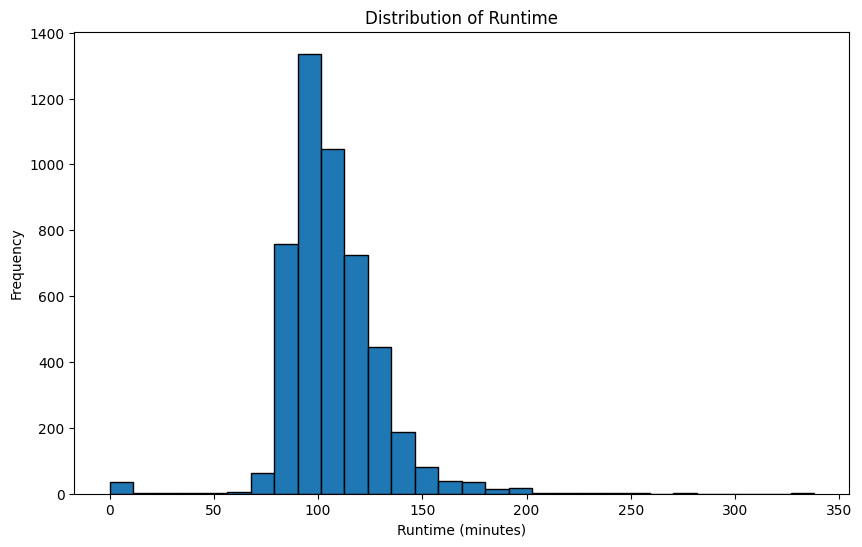

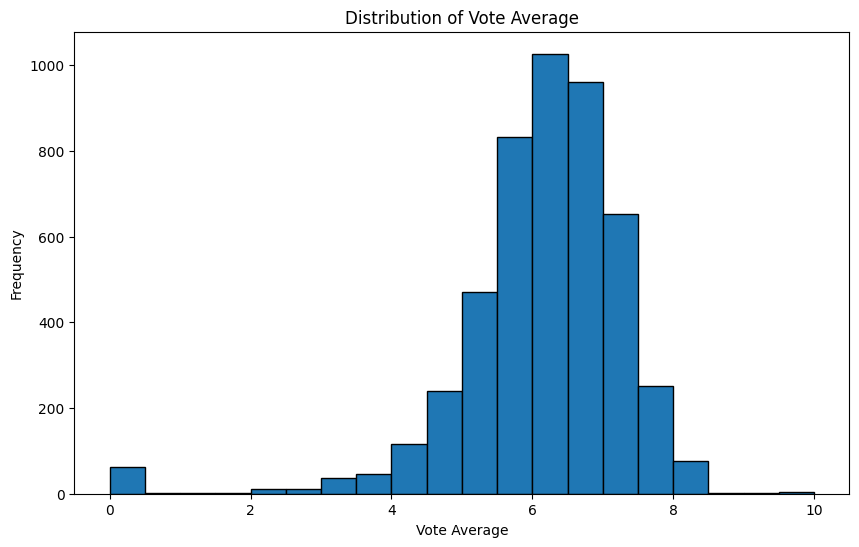

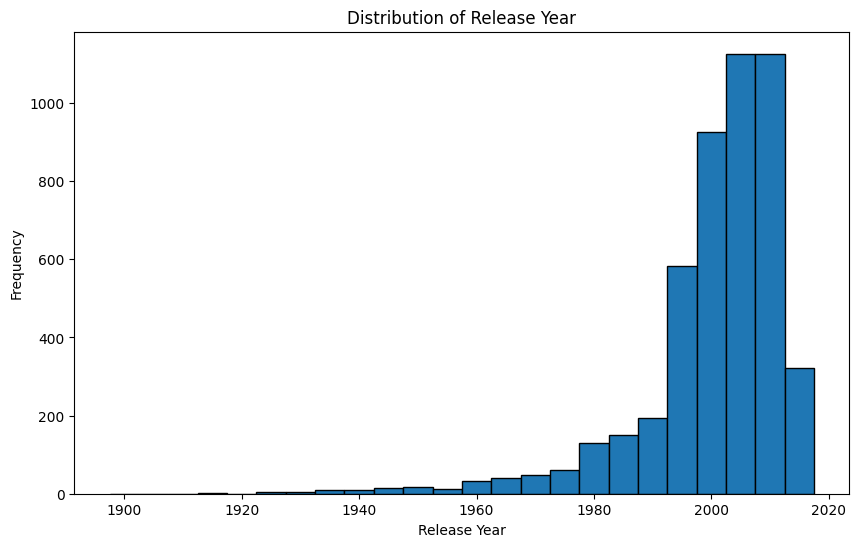

In [27]:
# Ensure the release_date column is converted to datetime and extract release year
tmdb_df_cleaned['release_date'] = pd.to_datetime(tmdb_df_cleaned['release_date'], errors='coerce')
tmdb_df_cleaned['release_year'] = tmdb_df_cleaned['release_date'].dt.year

# Plot histogram for runtime
plt.figure(figsize=(10,6))
plt.hist(tmdb_df_cleaned['runtime'].dropna(), bins=30, edgecolor='k')
plt.title("Distribution of Runtime")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Frequency")
plt.show()

# Plot histogram for vote_average
plt.figure(figsize=(10,6))
plt.hist(tmdb_df_cleaned['vote_average'].dropna(), bins=20, edgecolor='k')
plt.title("Distribution of Vote Average")
plt.xlabel("Vote Average")
plt.ylabel("Frequency")
plt.show()

# Plot histogram for release_year
plt.figure(figsize=(10,6))
plt.hist(tmdb_df_cleaned['release_year'].dropna(), bins=range(1900, 2025, 5), edgecolor='k', align='left')
plt.title("Distribution of Release Year")
plt.xlabel("Release Year")
plt.ylabel("Frequency")
plt.show()


# Feature Engineering
In this step, we will extract and preprocess both text and numerical features from our cleaned dataset.

Text Features:

We use the overview column as it contains descriptive information about the movies.

Missing values are filled with an empty string.

We apply a TfidfVectorizer to convert the text into numerical vectors.

The TfidfVectorizer is set to remove English stop words and limit the maximum features to 1000 for efficiency.

Numerical Features:

We use the runtime, vote_average, and release_year columns.

Missing values (if any) are handled appropriately before scaling.

StandardScaler is applied to normalize these numerical features.

Pipeline Construction:

The text and numerical transformations are combined using a ColumnTransformer, which creates a unified feature matrix that can be used in our machine learning models.